In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from datetime import date

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import pymc3 as pm
from pymc3 import glm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
!pip install statsmodels
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 102.0 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 KB 57.2 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import statsmodels.api as sm
import itertools
from ipywidgets import interact, interactive
from sklearn.impute import KNNImputer
import hashlib
%matplotlib inline

In [ ]:
monthly_stats_full = pd.read_csv('Monthly_Transportation_Statistics.csv')
us_2020 = pd.read_csv('2020_US_Region_Mobility_Report.csv')
us_2021 = pd.read_csv('2021_US_Region_Mobility_Report.csv')
us_2022 = pd.read_csv('2022_US_Region_Mobility_Report.csv')

# EDA

Visualization 1

In [ ]:
data = pd.concat([us_2020,us_2021,us_2022])
CA = data[data["sub_region_1"]=="California"]
Alameda = CA[CA["sub_region_2"]=="Alameda County"]

Text(0.5, 0, 'Days since February 15th 2020')

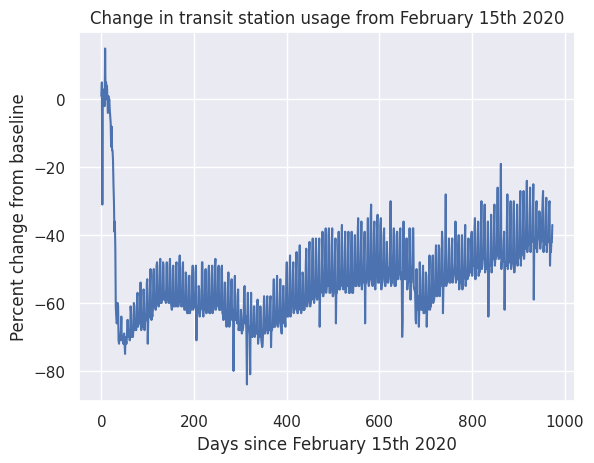

In [ ]:
plt.plot(range(len(Alameda)),Alameda["transit_stations_percent_change_from_baseline"])
plt.title("Change in transit station usage from February 15th 2020")
plt.ylabel("Percent change from baseline")
plt.xlabel("Days since February 15th 2020")

Visualization 2

In [ ]:
copy = monthly_stats_full.copy()
copy['Date'] = pd.to_datetime(copy['Date']).astype(str).str[:4].astype(int)
pass_miles = copy[['Date', 'Passenger Rail Passenger Miles']]
pass_miles_grouped = pass_miles.dropna().groupby(by='Date', as_index = False).sum()
new = pass_miles_grouped[pass_miles_grouped['Date'] > 1999]

Text(0, 0.5, 'Passenger Rail Passenger Miles')

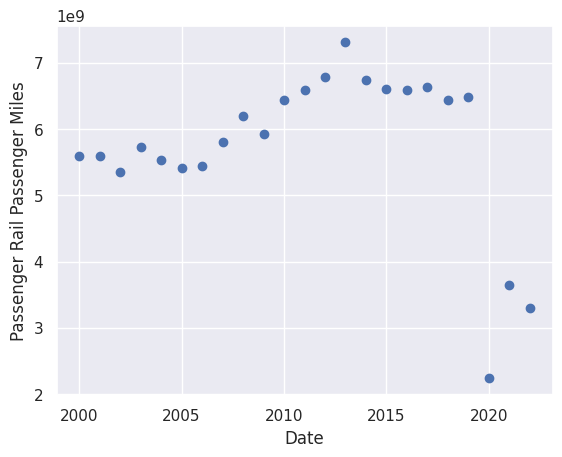

In [ ]:
# showing passenger rail passenger miles for each year from 2000 onwards
x2 = new['Date']
y2 = new['Passenger Rail Passenger Miles']
plt.scatter(x2, y2)
plt.xlabel('Date')
plt.ylabel('Passenger Rail Passenger Miles')

<AxesSubplot: xlabel='Passenger Rail Passenger Miles', ylabel='Count'>

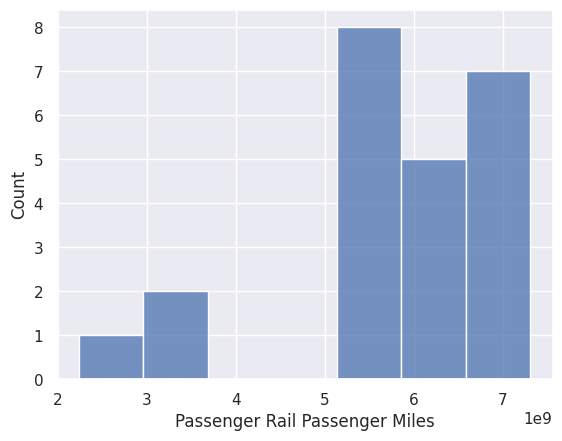

In [ ]:
# histogram showing counts of passenger rail passenger miles
sns.histplot(y2)

Visualization 3

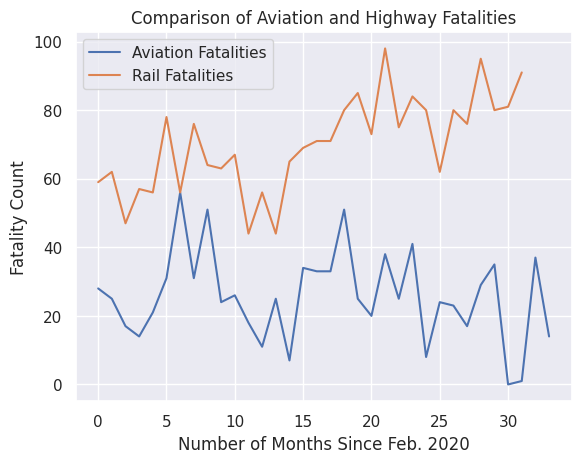

In [ ]:
US_transportation_stats = pd.read_csv("./Monthly_Transportation_Statistics.csv")
US_transportation_stats["Date"] = pd.to_datetime(US_transportation_stats['Date']).dt.floor('d')
start_index = US_transportation_stats[US_transportation_stats["Date"] == '02-01-2020'].index.astype(int)[0]
date_range = np.arange(start_index, len(US_transportation_stats) + 1)
duration = np.arange(start_index, len(US_transportation_stats) + 1) - start_index
aviation_fatalities_since_index = US_transportation_stats["Air Safety - General Aviation Fatalities"][date_range - 1]
rail_fatalities_since_index = US_transportation_stats["Rail Fatalities"][date_range - 1]
plt.plot(duration, aviation_fatalities_since_index, label="Aviation Fatalities")
plt.plot(duration, rail_fatalities_since_index, label="Rail Fatalities")
plt.legend()
plt.ylabel("Fatality Count")
plt.xlabel("Number of Months Since Feb. 2020")
plt.title("Comparison of Aviation and Highway Fatalities")
plt.show()

Visualization 4

Text(0.5, 0, 'Months since the start of 2017')

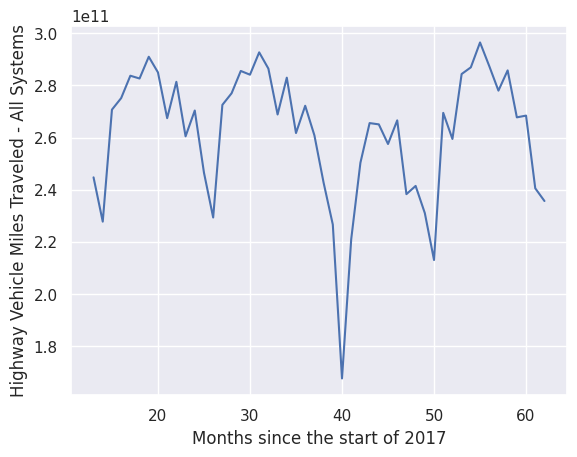

In [ ]:
US_transportation_stats = pd.read_csv("./Monthly_Transportation_Statistics.csv")
US_transportation_stats["Date"] = pd.to_datetime(US_transportation_stats['Date']).dt.floor('d')
start_index = US_transportation_stats[US_transportation_stats["Date"] == '01-01-2017'].index.astype(int)[0]
date_range = np.arange(start_index, len(US_transportation_stats) + 1)
duration = np.arange(start_index, len(US_transportation_stats) + 1) - start_index
highway_vehicle_miles_since_index = US_transportation_stats["Highway Vehicle Miles Traveled - All Systems"][date_range - 1]
plt.plot(duration, highway_vehicle_miles_since_index)
plt.ylabel("Highway Vehicle Miles Traveled - All Systems")
plt.xlabel("Months since the start of 2017")

# Research Question Results

Option C:  Prediction with GLMs and nonparametric methods

In [ ]:
monthly_stats_full["Date"] = pd.to_datetime(monthly_stats_full["Date"])
monthly_stats_full.columns = monthly_stats_full.columns.str.replace(" ","_")
monthly_stats_full.columns = monthly_stats_full.columns.str.replace(".","")
monthly_stats_full.columns = monthly_stats_full.columns.str.replace("_-_","_")
monthly_stats_full.columns = monthly_stats_full.columns.str.replace("(","")
monthly_stats_full.columns = monthly_stats_full.columns.str.replace(")","")
monthly_stats_full['Transit_All_Adjusted'] = monthly_stats_full['Transit_Ridership_Fixed_Route_Bus_Adjusted'] + monthly_stats_full['Transit_Ridership_Other_Transit_Modes_Adjusted'] + monthly_stats_full['Transit_Ridership_Urban_Rail_Adjusted']
stats = monthly_stats_full[monthly_stats_full["Date"]>="2017-01"][monthly_stats_full["Date"]<"2022-08"]

stats["log_transit_bus"] = np.log(stats["Transit_Ridership_Fixed_Route_Bus_Adjusted"])
stats["log_light_truck_sales"] = np.log(stats["Light_truck_sales_SAAR_millions"])
stats["log_transit_all"] = np.log(stats["Transit_All_Adjusted"])
stats["log_govspending_land_passenger_terminal"] = np.log(stats['State_and_Local_Government_Construction_Spending_Land_Passenger_Terminal'])

In [ ]:
stats_20yrs = monthly_stats_full[monthly_stats_full["Date"]>="2002-01"][monthly_stats_full["Date"]<"2022-08"]
stats_20yrs = stats_20yrs.dropna(axis=1)

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, log_govspending_land_passenger_terminal, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 94 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


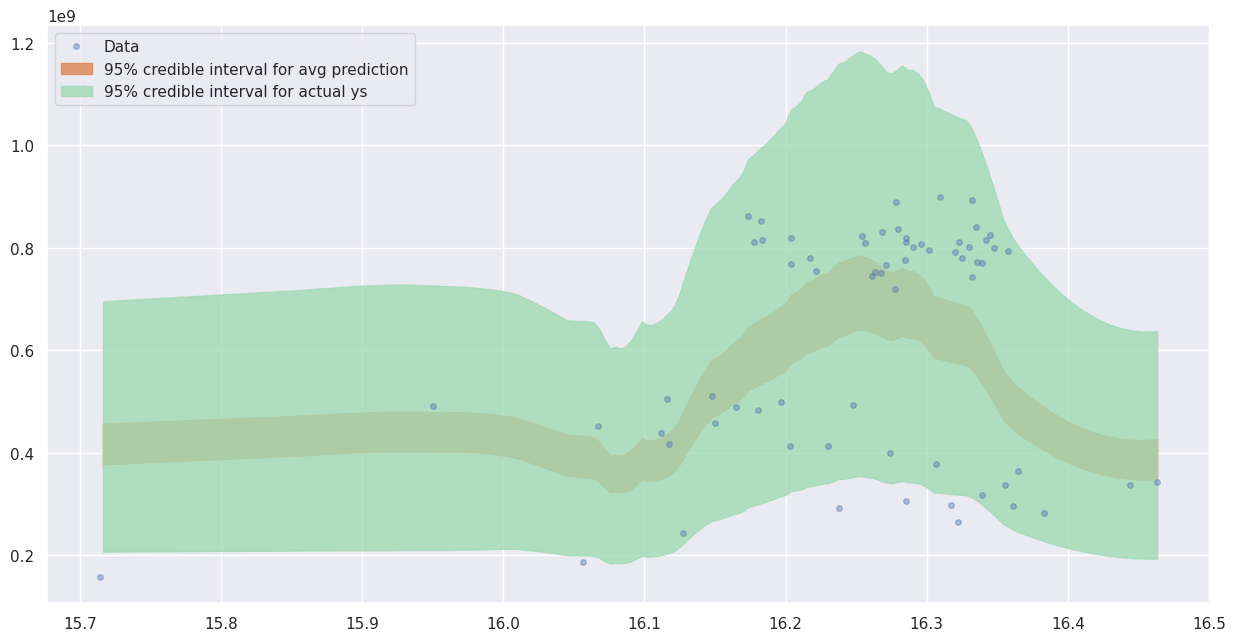

In [ ]:
#Bayesian model
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('log_transit_all ~ log_govspending_land_passenger_terminal', stats)
    gaussian_trace = pm.sample()

#This shows the correlation between State_and_Local_Government_Construction_Spending_Land_Passenger_Terminal and transit usage.
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
    gaussian_trace, var_names = ['log_govspending_land_passenger_terminal','Intercept','y']
    )

def compute_avg_prediction(ppc): #From Lec 12
    linear_part = np.outer(ppc["log_govspending_land_passenger_terminal"], stats.log_govspending_land_passenger_terminal.values) + ppc["Intercept"][:,np.newaxis]
    return np.exp(linear_part)

y_hat_gaussian = compute_avg_prediction(gaussian_ppc)

#Plotting code from lecture 12
_, ax = plt.subplots(1,1, figsize = (15,7.5), dpi=100)
ax.plot(stats.log_light_truck_sales,stats.Transit_All_Adjusted, 'o', ms=4, alpha=0.4, label='Data')
az.plot_hdi(
    stats.log_light_truck_sales,
    y_hat_gaussian,
    ax=ax,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.8, "label": "95% credible interval for avg prediction"},)
az.plot_hdi(
    stats.log_light_truck_sales,
    np.exp(gaussian_ppc['y']),
    ax=ax,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for actual ys"},)
ax.legend()

In [ ]:
#Frequentist GLM

stats_nonan = monthly_stats_full[monthly_stats_full["Date"]>="2002-01"][monthly_stats_full["Date"]<"2022-08"]
stats_nonan = stats_nonan.dropna(axis=1)
#best_features are the features with the most correlation found in the data.
best_features = ['State_and_Local_Government_Construction_Spending_Land_Passenger_Terminal',
                 'State_and_Local_Government_Construction_Spending_Runway',
                 'State_and_Local_Government_Construction_Spending_Air_Passenger_Terminal',
                 'State_and_Local_Government_Construction_Spending_Transportation',
                 'State_and_Local_Government_Construction_Spending_Performance_/_Meeting_Center',
                 'State_and_Local_Government_Construction_Spending_Library_/_Archive',
                 'State_and_Local_Government_Construction_Spending_Other_Educational',
                 'State_and_Local_Government_Construction_Spending_Higher_Education',
                 'State_and_Local_Government_Construction_Spending_Primary/Secondary_Schools',
                 'State_and_Local_Government_Construction_Spending_Educational',
                 'Highway_Fuel_Price_On-highway_Diesel',
                 'Highway_Fuel_Price_Regular_Gasoline',
                 'Heavy_truck_sales',
                 'Light_truck_sales',
                 'Auto_sales',
                 'Truck_tonnage_index',
                ]

#The features with the largest z-score are the most correlated with transit usage.
#For instance, State_and_Local_Government_Construction_Spending_Land_Passenger_Terminal and Heavy_truck_sales.
X = stats_nonan[best_features]
y = stats_nonan['Transit_All_Adjusted']
gaussian_model = sm.GLM(y,sm.add_constant(X),family=sm.families.Gaussian())
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     Transit_All_Adjusted   No. Observations:                  247
Model:                              GLM   Df Residuals:                      230
Model Family:                  Gaussian   Df Model:                           16
Link Function:                 identity   Scale:                      6.1318e+15
Method:                            IRLS   Log-Likelihood:                -4831.2
Date:                  Mon, 12 Dec 2022   Deviance:                   1.4103e+18
Time:                          00:19:12   Pearson chi2:                 1.41e+18
No. Iterations:                       3   Pseudo R-squ. (CS):             0.9478
Covariance Type:              nonrobust                                         
                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

Non-parametric Model

In [ ]:
# non parametric model - random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

stats = stats.fillna(stats.mean())
X_rf = stats[['State_and_Local_Government_Construction_Spending_Mass_Transit',
           'US_Airline_Traffic_Total_Non_Seasonally_Adjusted','Unemployed_Seasonally_Adjusted']]
y_rf = stats['Transit_Ridership_Fixed_Route_Bus_Adjusted']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)
model_rf = RandomForestClassifier(n_estimators = 100, random_state=42, max_depth=8)
model_rf.fit(X_train_rf, y_train_rf)
y_pred_rf = model_rf.predict(X_test_rf)
abs_loss_rf = mean_absolute_error(y_test_rf, y_pred_rf)
abs_loss_rf

31033340.42857143

Option D: Causal Inference

In [ ]:
US_transportation_stats = pd.read_csv("./Monthly_Transportation_Statistics.csv")
US_transportation_stats["Date"] = pd.to_datetime(US_transportation_stats['Date']).dt.floor('d')
start_index = US_transportation_stats[US_transportation_stats["Date"] == '02-01-2020'].index.astype(int)[0]
date_range = np.arange(start_index, len(US_transportation_stats) + 1)
duration = np.arange(start_index, len(US_transportation_stats) + 1) - start_index

target_stats = US_transportation_stats.loc[start_index:, :]

In [ ]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False): 
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [ ]:
target_stats_wo_index_date = target_stats.iloc[:, 2:]
imputer = KNNImputer(n_neighbors=3)
imputed_stats_wo_index_date = pd.DataFrame(columns = target_stats_wo_index_date.columns,\
                                          data = imputer.fit_transform(target_stats_wo_index_date))

In [ ]:
airline_traffic = imputed_stats_wo_index_date.loc[6:,\
    ['U.S. Airline Traffic - Total - Seasonally Adjusted']]
airline_construction = imputed_stats_wo_index_date.loc[:34-7,\
    ['State and Local Government Construction Spending - Runway',\
     'State and Local Government Construction Spending - Air Passenger Terminal',\
     'State and Local Government Construction Spending - Air']]
airline_traffic.reset_index(drop=True, inplace=True)
airline_construction.reset_index(drop=True, inplace=True)
airline_stats = pd.concat([airline_traffic, airline_construction], axis=1)

airline_model = fit_OLS_model(airline_stats, 'U.S. Airline Traffic - Total - Seasonally Adjusted',\
                                             ['State and Local Government Construction Spending - Air'])
print(airline_model.summary())

                                                 OLS Regression Results                                                
Dep. Variable:     U.S. Airline Traffic - Total - Seasonally Adjusted   R-squared (uncentered):                   0.851
Model:                                                            OLS   Adj. R-squared (uncentered):              0.845
Method:                                                 Least Squares   F-statistic:                              153.9
Date:                                                Mon, 12 Dec 2022   Prob (F-statistic):                    1.15e-12
Time:                                                        00:19:13   Log-Likelihood:                         -513.33
No. Observations:                                                  28   AIC:                                      1029.
Df Residuals:                                                      27   BIC:                                      1030.
Df Model:                               

In [ ]:
highway_usage = imputed_stats_wo_index_date.loc[6:,\
    ['Highway Vehicle Miles Traveled - All Systems']]
highway_construction = imputed_stats_wo_index_date.loc[:34-7,\
    ['State and Local Government Construction Spending - Highway and Street',\
     'State and Local Government Construction Spending - Pavement']]
highway_usage.reset_index(drop=True, inplace=True)
highway_construction.reset_index(drop=True, inplace=True)
highway_stats = pd.concat([highway_usage, highway_construction], axis=1)

highway_model = fit_OLS_model(highway_stats, 'Highway Vehicle Miles Traveled - All Systems',\
   ['State and Local Government Construction Spending - Highway and Street'])
print(highway_model.summary())

                                              OLS Regression Results                                             
Dep. Variable:     Highway Vehicle Miles Traveled - All Systems   R-squared (uncentered):                   0.897
Model:                                                      OLS   Adj. R-squared (uncentered):              0.893
Method:                                           Least Squares   F-statistic:                              234.3
Date:                                          Mon, 12 Dec 2022   Prob (F-statistic):                    7.89e-15
Time:                                                  00:19:13   Log-Likelihood:                         -744.42
No. Observations:                                            28   AIC:                                      1491.
Df Residuals:                                                27   BIC:                                      1492.
Df Model:                                                     1                         

In [ ]:
ridership_mass = imputed_stats_wo_index_date.loc[6:, 'Transit Ridership - Urban Rail - Adjusted']\
    + imputed_stats_wo_index_date.loc[6:, 'Transit Ridership - Fixed Route Bus - Adjusted']
transportation_construction = imputed_stats_wo_index_date.loc[:34-7,\
    ['State and Local Government Construction Spending - Mass Transit',\
     'State and Local Government Construction Spending - Transportation']]
ridership_mass.reset_index(drop=True, inplace=True)
transportation_construction.reset_index(drop=True, inplace=True)
ridership_stats = pd.concat([ridership_mass, transportation_construction], axis=1)
ridership_stats = ridership_stats.rename(columns={ ridership_stats.columns[0]: "Ridership_mass" })

ridership_model = fit_OLS_model(ridership_stats, 'Ridership_mass',\
    ['State and Local Government Construction Spending - Mass Transit'])
print(ridership_model.summary())

                                 OLS Regression Results                                
Dep. Variable:         Ridership_mass   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              408.0
Date:                Mon, 12 Dec 2022   Prob (F-statistic):                    7.92e-18
Time:                        00:19:13   Log-Likelihood:                         -555.81
No. Observations:                  28   AIC:                                      1114.
Df Residuals:                      27   BIC:                                      1115.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                                                                      coef    std err          t      P>|t|      [0.025 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=70aef39d-bcc2-4d97-a9b5-b53985789220' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>